## Create a Visual for Markowitz Portfolio Theory

Using https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/ as a reference

## Read Packages

In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
from pylab import rcParams
solvers.options['show_progress'] = False

In [3]:
import plotly as py
import plotly.tools as tls
from plotly.graph_objs import *

## Simulate Data

Simulate data with set number of observations and assets from a normal distribution

In [28]:
## Set number of assets
n_assets = 4

## Set number of observations
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs) + 5

## Create Random Weights

Creates a function that returns random weights for the number of assets

In [5]:
def rand_weights(n):
    '''Produces n random weights that sum to 1'''
    k = np.random.rand(n)
    return k / sum(k)

## Create Random Portfolio

A function that returns mean and standard deviation of returns for a random portfolio

Returns $R = p^T w$ and $\sigma = \sqrt{w^T Cw}$

In [6]:
def random_portfolio(returns):
    '''
    Returns the mean and standard deviation of returns for a randomly generated portfolio
    '''
    
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # Test for outliers to make plot prettier
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

## Generate a specified number of random portfolios

In [29]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec)
    for _ in range(n_portfolios)
])

## Plot

Text(0.5, 1.0, 'Mean and standard deviation of returns of randomly generated portfolios')

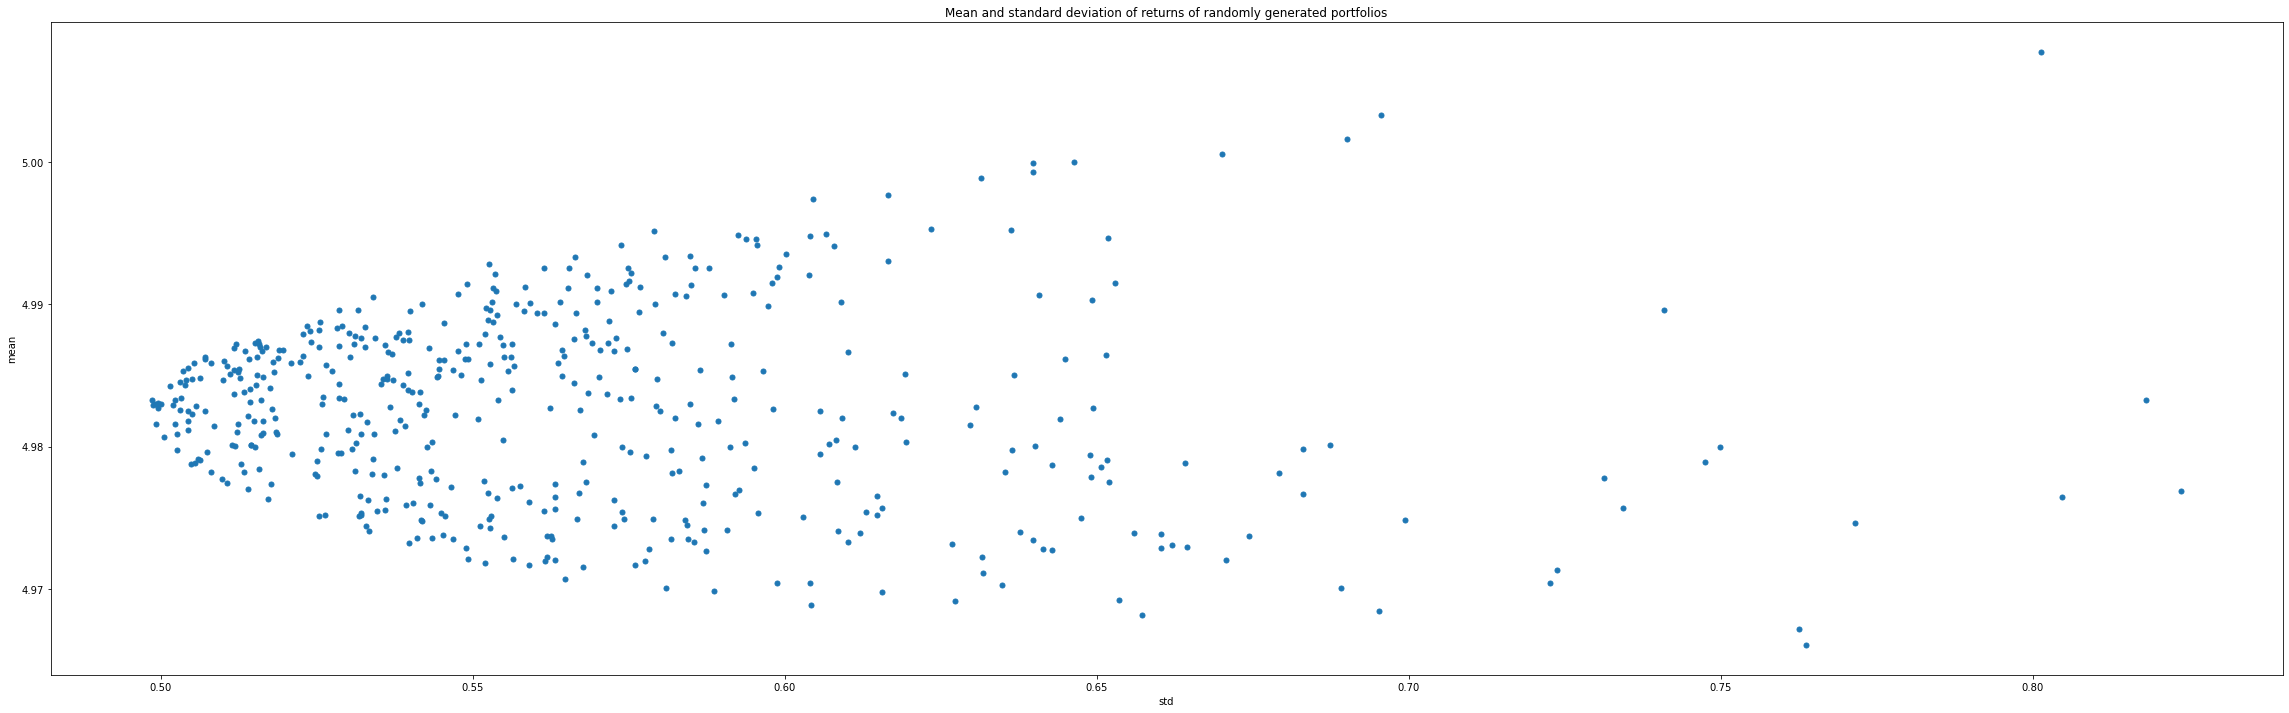

In [30]:
fig = plt.figure()
plt.plot(stds, means, 'o', markersize = 5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

## Function that performs Markowitz optimization and generates efficiency frontier

Minimizes $w^TCw$ where $\sum_i w_i = 1$

In [32]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis = 1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n)) # negative nxn identity matrix
    h = opt.matrix(0.0, (n,1))
    A = opt.matrix(1.0, (1,n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## Calculate risk and returns for frontier
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## Calculate the 2nd degree polynomail of the frontier curve
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    ## Calculate the optimal portfolio
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

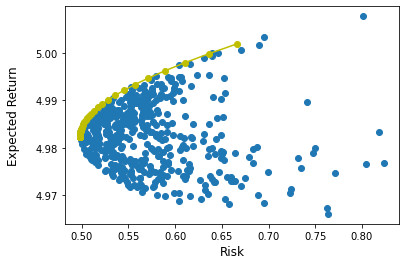

In [36]:
weights, returns, risks = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('Expected Return', labelpad = 15, fontsize = 12)
plt.xlabel('Risk', fontsize = 12)
plt.plot(risks, returns, 'y-o')

rcParams['figure.figsize'] = 40, 12
plt.savefig('EfficiencyFrontierPlot.png', dpi = 199, bbox_inches='tight')

In [24]:
# https://plotly.com/python/v3/ipython-notebooks/markowitz-portfolio-optimization/
print(weights)
np.array(returns).shape

[[2.08663425e-01]
 [2.90282100e-01]
 [2.82625307e-07]
 [5.01054192e-01]]


(100,)